# DATA5710 - Assignment 1

## Bayesian Linear Regression and Gaussian Processes

**Semester 1, 25 February 2021**



Lecturers and Tutors: Roman Marchant and Richard Scalzo

In [2]:
## Background Description

The goal is to produce an estimate of global mean sea level from regression models for specific dates. The source of data for this assignment is the historical sea level data from setellite altimetry (NOAA, Laboratory for Satellite Altimetry).

The data can be downloaded from [NOASS'S website](https://www.star.nesdis.noaa.gov/socd/lsa/SeaLevelRise/LSA_SLR_timeseries_global.php), and we are specifically interested in a subset of the data correspondig to the [Jason-2 satellite](https://www.jpl.nasa.gov/missions/jason-2), where seasonal signals are retained. The CSV file can be found [here](https://www.star.nesdis.noaa.gov/socd/lsa/SeaLevelRise/slr/slr_sla_gbl_keep_txj1j2_90.csv).

The task is the following:

1. Download and normalise the data provided by Jason-2 satellite.
2. Use bayesian linear regression and gaussian processes to predict the value of mean sea level (in [mm], not normalised) for two dates: t_1 = 2013.2265 and for t_2 = 2017.5012. You are expected to provide the full predictive gaussian distribution for these dates for the two methods, including the expected value and variance. Make whatever assumptions you deem necessary commenting on the justifications, including the family of basis functions, $\alpha$ and $\beta$ for BLR and the kernel function for GPs.

3. Comment on the suitability of the different methods for prediction sea level in both dates in (2). (max 300 words)

You are encouraged to re-use most of the code from the tutorials and deliver this python notebook as a completed file with your anlaysis.

SyntaxError: invalid syntax (<ipython-input-2-4be1de1f8121>, line 3)

In [4]:
import numpy as np # Numpy is a popular numeric computation package
import pandas as pd # Pandas is a friendly data wrangling package/library
from scipy import linalg


In [8]:
## 1. Download data and normalise

In [6]:
os.chdir("/Users/megannguyen/Desktop/DATA 5711")
df_jason2 = pd.read_csv("jason2.csv", comment = "#")
print(df_jason2)

           year  TOPEX/Poseidon  Jason-1  Jason-2  Jason-3
0     1992.9614          -16.27      NaN      NaN      NaN
1     1992.9865          -17.97      NaN      NaN      NaN
2     1993.0123          -14.87      NaN      NaN      NaN
3     1993.0407          -19.87      NaN      NaN      NaN
4     1993.0660          -25.27      NaN      NaN      NaN
5     1993.0974          -29.37      NaN      NaN      NaN
6     1993.1206          -27.67      NaN      NaN      NaN
7     1993.1493          -21.87      NaN      NaN      NaN
8     1993.1765          -18.97      NaN      NaN      NaN
9     1993.2037          -19.47      NaN      NaN      NaN
10    1993.2307          -22.97      NaN      NaN      NaN
11    1993.2851          -26.27      NaN      NaN      NaN
12    1993.3123          -20.07      NaN      NaN      NaN
13    1993.3394          -19.87      NaN      NaN      NaN
14    1993.3665          -17.17      NaN      NaN      NaN
15    1993.3937          -22.07      NaN      NaN      N

In [7]:
df_jason2 = df_jason2[['year','TOPEX/Poseidon']]

In [8]:
df_jason2 = df_jason2.dropna()

In [10]:
x = df_jason2['year'].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = df_jason2['TOPEX/Poseidon'].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit

print(f"x has shape ({x.shape[0]},{x.shape[1]}) and has range [{np.min(x):.3f},{np.max(x):.3f}]")
print(f"y has shape ({y.shape[0]},{y.shape[1]}) and has range [{np.min(y):.3f},{np.max(y):.3f}]")

x has shape (440,1) and has range [1992.961,2005.766]
y has shape (440,1) and has range [-29.370,24.930]


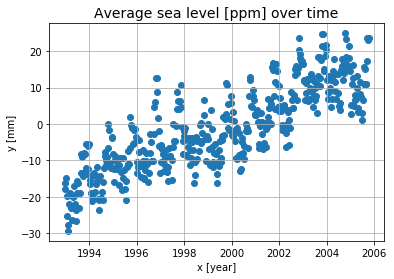

In [11]:
import matplotlib.pylab as pl
%matplotlib inline

#scatter plot of y vs. x
pl.scatter(x, y) # Interpolation data
pl.title('Average sea level [ppm] over time', fontsize=14)
pl.xlabel('x [year]')
pl.ylabel('y [mm]')
pl.grid()

In [12]:
def normalise1D(z, new_min=0, new_max=1): 
    z_min = np.min(z)
    z_max = np.max(z)
    z_normalised = new_min + (z - z_min)*(new_max - new_min)/(z_max - z_min) 
    return z_normalised

x_norm = normalise1D(x) # You could overwrite x, however I recommend to create a new variable to avoid loosing track of variables
y_norm = normalise1D(y)


In [13]:
#Normalize 2 years

def normalise2values(t, new_min=0, new_max=1): 
    t_min = np.min(x)
    t_max = np.max(x)
    t_normalised = new_min + (t - t_min)*(new_max - new_min)/(t_max - t_min) 
    return t_normalised

t_1 = 2013.2265
t_1_norm = normalise2values(t_1)
print(t_1_norm)
t_2 = 2017.5012
t_2_norm = normalise2values(t_2)
print(t_2_norm)

1.5826916168132343
1.9165430093250608


Training set contains 308 observations.
Test set contains 132 observations.


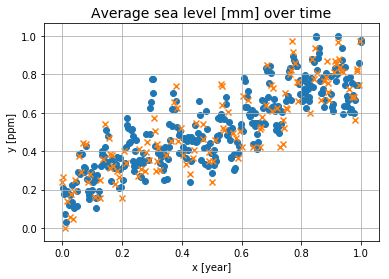

In [14]:
#Divide into training and test set
random_indices = np.random.permutation(x.shape[0])
train_ratio = .7
n_train = int(np.floor(x_norm.shape[0]*train_ratio))
n_test = x_norm.shape[0]-n_train
train_idx, test_idx = random_indices[:n_train], random_indices[n_train:]
x_norm_train, x_norm_test = x_norm[train_idx,:], x_norm[test_idx,:]
y_norm_train, y_norm_test = y_norm[train_idx,:], y_norm[test_idx,:]

print(f"Training set contains {y_norm_train.shape[0]} observations.")
print(f"Test set contains {y_norm_test.shape[0]} observations.")

pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.title('Average sea level [mm] over time', fontsize=14)
pl.xlabel('x [year]')
pl.ylabel('y [ppm]')
pl.grid()

In [9]:
## 2. Bayesian Linear Regression

In [15]:
from scipy.stats import multivariate_normal

In [16]:
def generate_feature_mat(x_in, p):
    theta_x_in = x_in**np.arange(p+1) 
    #to the power of p is the number of basis fns
    return theta_x_in

In [17]:
p = 1
phi_x = generate_feature_mat(x_norm, p) 

In [18]:
#prior distribution
alpha = 0.01**-1
prior = multivariate_normal(np.zeros(p+1), 1/alpha*np.eye(p+1))

#posterior distribution
beta = 25
S_N = np.linalg.pinv(alpha*np.eye((p+1)) + beta*phi_x.T.dot(phi_x))
m_N = beta*S_N.dot(phi_x.T.dot(y_norm))
posterior = multivariate_normal(m_N[:,0], S_N)


Text(0.5, 1.0, 'Bayesian linear regression ')

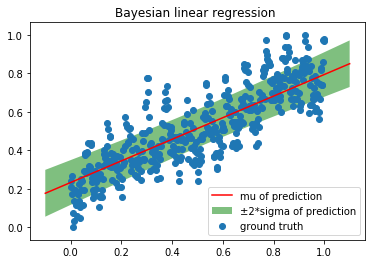

In [19]:
x_q = np.linspace(-0.1, 1.1, 60)[:,np.newaxis] 
phi_x_q = generate_feature_mat(x_q, p) 

#Mean and variance of predictive distribution
mu_q = m_N.T.dot(phi_x_q.T).ravel()
sigma_q = np.sqrt(np.diag(phi_x_q.dot(S_N.dot(phi_x_q.T)))) + 1.0 / beta

pl.fill_between(x_q.ravel(), mu_q-2*sigma_q, mu_q+2*sigma_q, \
                facecolor='green', interpolate=True, alpha=0.5, label='±2*sigma of prediction')
pl.scatter(x_norm, y_norm, label='ground truth')
pl.plot(x_q, mu_q, c='red', label='mu of prediction')
pl.legend(loc='lower right')
pl.title('Bayesian linear regression ')

In [20]:
#Draw random weights from distribution
w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
#For 2 years we need to predict
x_predict = np.array([1.5826916168132343, 1.9165430093250608])[:,np.newaxis] 
phi_x_predict = generate_feature_mat(x_predict, p) 

y_samples = phi_x_predict.dot(w_samples)

In [21]:
print(w_samples)
print(y_samples)

[[0.23499893 0.24398163 0.2273334  0.24426805 0.22855488]
 [0.56959454 0.53044183 0.54467574 0.55638396 0.57615511]]
[[1.13649143 1.08350746 1.08938713 1.12485229 1.14043074]
 [1.32665136 1.26059621 1.27122788 1.31060185 1.33278092]]


In [27]:
#Denormalise predictions
def denormalise(w, new_min=0, new_max=1): 
    w_min = np.min(y)
    w_max = np.max(y)
    w_denormalised = (w_max - w_min)* w - w_min 
    return w_denormalised
#We predict sea level of two years 
y_predict = denormalise(y_samples)
print(y_predict)

[[ 91.08148445  88.20445526  88.52372093  90.44947917  91.29538905]
 [101.40716859  97.82037396  98.39767391 100.53568032 101.74000406]]


In [ ]:
## 3. Gaussian Processes

In [28]:
class GP:
    def __init__(self,cov_function_name, x_train, y_train, hyper_params, sigma_n):
        self.cov_function_name = cov_function_name
        self.x_train = x_train
        self.y_train = y_train
        self.hyper_params = hyper_params #params[0] is signal variance, params[1] is lengthscale
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def predict(self,x_star):
        k_star = self.cov_func(self.x_train,x_star)
        f_mean = np.dot(np.dot(np.transpose(k_star),self.K_inv),self.y_train)
        f_std = self.cov_func(x_star, x_star) - np.dot(np.dot(np.transpose(k_star),self.K_inv),k_star)+np.eye(x_star.shape[0])*(self.sigma_n**2)
        f_std = np.sqrt(np.diag(f_std))[:,np.newaxis]
        return [f_mean,f_std]

    def cov_func(self,x_1,x_2):
        if self.cov_function_name == "Squared Exponential":
            x_1_sq = np.sum(np.square(x_1),1)
            x_2_sq = np.sum(np.square(x_2),1)
            d = -2.*np.dot(x_1, x_2.T) + (x_1_sq[:,None] + x_2_sq[None,:])
            d = np.sqrt(np.clip(d, 0, np.inf))/self.hyper_params[1]
            K = self.hyper_params[0] * np.exp(-0.5 * d**2)
        return K
    
    def set_hyper_params(self, hyper_params, sigma_n):
        self.hyper_params = hyper_params
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def log_marginal_likelihood(self):
        lml1 = -.5*np.dot(np.dot(np.transpose(self.y_train),self.K_inv),self.y_train)
        lml2 = -.5*np.linalg.det(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        lml3 = -.5*self.x_train.shape[0]*np.log(2*np.pi)
        return lml1+lml2+lml3

In [38]:
#Choose covariance function
def squared_exponential(x_1,x_2, signal_variance, lengthscale): #calc sq distance of 2 vectors
    x_1_sq = np.sum(np.square(x_1),1)
    x_2_sq = np.sum(np.square(x_2),1)
    d = -2.*np.dot(x_1, x_2.T) + (x_1_sq[:,None] + x_2_sq[None,:])
    d = np.sqrt(np.clip(d, 0, np.inf))/lengthscale
    K = signal_variance * np.exp(-0.5 * d**2)
    return K

In [51]:
x_star = np.linspace(0,1,100)[:,np.newaxis]

Log Marginal Likelihood: [[-460.01145844]]


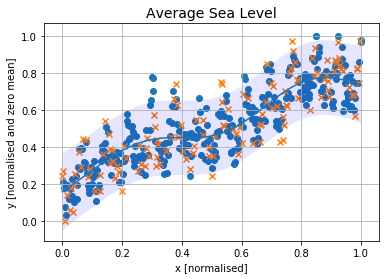

In [52]:
#Predict using arbitrary hyperparameters
signal_variance = 1
lengthscale = 0.3
sigma_n = 0.1
gp = GP("Squared Exponential", x_norm_train, y_norm_train, [signal_variance,lengthscale], sigma_n)
[f_mean_2,f_std_2] = gp.predict(x_star)
lml = gp.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))

pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.fill_between(x_star.ravel(), (f_mean_2-2*f_std_2).ravel(), (f_mean_2+2*f_std_2).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, f_mean_2)
pl.title('Average Sea Level', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.grid()

In [81]:
#Optimize hyperparameters

lengthscale_vals = np.logspace(-4,1,800)
lml_vals = np.zeros((lengthscale_vals.shape[0],1))

from scipy.optimize import minimize

def eval_params(params, gp):
    params = np.exp(params)
    gp.set_hyper_params(params[:-1],params[len(params)-1])
    nlml = -gp.log_marginal_likelihood()
    print(str(params)+str(nlml))
    return nlml

x0 = np.array([np.log(10), np.log(0.1), np.log(0.1)])
res = minimize(eval_params, x0, method='nelder-mead', args=(gp),
               options={'xatol': 1e-10, 'disp': True})
print(res)

1144]]
[10.66050499  0.07742637  0.12915497][[382.60784187]]
[10.39122304  0.06812921  0.14677993][[358.79234626]]
[12.2712524   0.07262918  0.16681005][[342.58149581]]
[13.59356391  0.06556418  0.21544347][[318.15077417]]
[11.65914401  0.06309573  0.21544347][[317.64786247]]
[11.65914401  0.05411695  0.29286446][[298.98424173]]
[12.42923629  0.04354005  0.35030347][[290.5619779]]
[13.08177474  0.0304322   0.58434141][[285.50343995]]
[15.64748142  0.03328298  0.75470596][[284.60996948]]
[19.20141939  0.02326305  1.7113283 ][[4.74828617e+205]]
[13.13767513  0.02200861  1.18597101][[7.77394537e+116]]
[13.47812965  0.04990547  0.33000348][[293.54144513]]
[16.87176407  0.02526208  0.94473203][[2.52089277e+62]]
[12.78763182  0.04473189  0.3924887 ][[289.42629261]]
[14.09195324  0.02546637  0.94115803][[5.06116664e+57]]
[13.62903229  0.04217964  0.42884912][[288.07138656]]
[15.49746382  0.02732048  0.83947059][[1.44492051e+29]]
[13.417072    0.03954441  0.47464809][[287.00939463]]
[14.389561

Optimal signal variance: 23.630943424408677
Optimal lengthscale: 0.03493545559896306
Optimal noise std: 0.7554689582165688


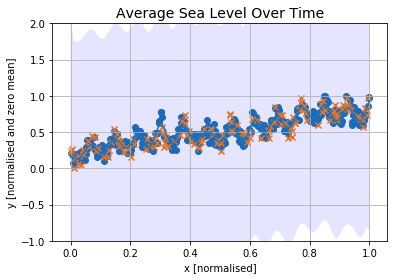

In [82]:
optimal_params = np.exp(res.x)

print("Optimal signal variance: "+str(optimal_params[0]))
print("Optimal lengthscale: "+str(optimal_params[1]))
print("Optimal noise std: "+str(optimal_params[2]))

gp.set_hyper_params([optimal_params[0],optimal_params[1]],optimal_params[2])

[f_mean,f_std] = gp.predict(x_star)

pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.fill_between(x_star.ravel(), (f_mean-2*f_std).ravel(), (f_mean+2*f_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, f_mean)
pl.title('Average Sea Level Over Time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.ylim([-1,2])
pl.grid()

In [79]:
#Expected value and variance of two dates normalised

y_gaussian = gp.predict(x_predict)
y_gaussian_mean = [item[:,0] for item in y_gaussian]
y_gaussian_mean

[array([1.22180037e-060, 9.63603425e-150]), array([4.91952055, 4.91952055])]

In [ ]:
## 4. Compare suitability
"""
Looking at the ground truth, the data generally follow a positive linear regression (as the years go by the average sea level goes up). Hence, the Bayesian linear regression is more suitable to predict the sea levels of two future years. GP gives a neat way to optimize hyperparameters but the it takes longer to compute. A GP kernel is useful to specify prior on a function space, but choice of kernel function can be challenging. For example, I used squared exponential as a covariance function, and I got extremely low normalised predicted mean.
"""